<a href="https://colab.research.google.com/github/thu4n/testing-model-notebook/blob/main/Copy_of_Lenet_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment preparations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from six.moves import urllib
import tempfile
import glob

import numpy as np
import pandas as pd
import tensorflow as tf

# Examine software versions
print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
2.11.0
2.11.0


In [ ]:
# Utilizing GPU for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if (len(physical_devices) > 0):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
tf.keras.backend.clear_session()

## Loading dataset

In [ ]:
external_path = '/content/drive/MyDrive/PREP_N5_CSI_DATA'
!ls $external_path # Checking directory

A_100.npy  A_304.npy  B_151.npy  B_355.npy  C_19.npy   C_46.npy   D_250.npy
A_101.npy  A_305.npy  B_152.npy  B_356.npy  C_1.npy    C_47.npy   D_251.npy
A_102.npy  A_306.npy  B_153.npy  B_357.npy  C_200.npy  C_48.npy   D_252.npy
A_103.npy  A_307.npy  B_154.npy  B_358.npy  C_201.npy  C_49.npy   D_253.npy
A_104.npy  A_308.npy  B_155.npy  B_359.npy  C_202.npy  C_4.npy	  D_254.npy
A_105.npy  A_309.npy  B_156.npy  B_35.npy   C_203.npy  C_50.npy   D_255.npy
A_106.npy  A_30.npy   B_157.npy  B_360.npy  C_204.npy  C_51.npy   D_256.npy
A_107.npy  A_310.npy  B_158.npy  B_361.npy  C_205.npy  C_52.npy   D_257.npy
A_108.npy  A_311.npy  B_159.npy  B_362.npy  C_206.npy  C_53.npy   D_258.npy
A_109.npy  A_312.npy  B_15.npy	 B_363.npy  C_207.npy  C_54.npy   D_259.npy
A_10.npy   A_313.npy  B_160.npy  B_364.npy  C_208.npy  C_55.npy   D_25.npy
A_110.npy  A_314.npy  B_161.npy  B_365.npy  C_209.npy  C_56.npy   D_260.npy
A_111.npy  A_315.npy  B_162.npy  B_366.npy  C_20.npy   C_57.npy   D_261.npy
A_112.npy  A_31

In [ ]:
# Creating list of filenames
filenames = glob.glob(external_path + "/*.npy")
filenames_p = [i.split('/')[-1] for i in filenames]

In [ ]:
!rm -rf ./csi_data

In [ ]:
# Copying data to local environment for quicker loading to numpy
!cp -r $external_path ./csi_data

In [ ]:
# Creating empty lists to store data and labels
all_data = []
all_labels = []

# Reading data from numpy files and adding to empty list
matrlen = 500
for f in filenames_p:
  matr_abs = np.load('./csi_data' + '/' + f)
  filtermatr = np.zeros((52, matrlen))
  N = 5
  temp = 0
  matr_abs = matr_abs.transpose()
  for x in range(52):
    for y in range(matrlen):
      if (y + 1 <= matrlen - N):
        temp = 0
        for z in range(y, y + N):
          temp = temp + matr_abs[x][z]
        filtermatr[x][y] = temp / N
      else:
        temp = 0
        for w in range(y - N, y):
          temp = temp + matr_abs[x][w]
        filtermatr[x][y] = temp / N
  filtermatr = filtermatr.transpose()


  file_data = filtermatr
  thresh = np.zeros(500)
  pack_avg = np.zeros(500)
  sub_avg = np.zeros(500)
  sub_max = np.zeros(500)
  r = 0.9
  d_relo = np.zeros((500, 52))
  for i in range(500):
    sub_avg[i] = sum(file_data[i, :]) / 52
  start_p = 0  # starting point
  end_p = 499  # ending point
  avg = sum(sub_avg) / 500  # get average value of 500 packets with 52 subcarriers for each

  for j in range(500):
      pack_avg[j] = avg  # create a packet's average value line
      if sub_avg[j] < avg:
          sub_avg[j] = 2 * avg - sub_avg[j]
      sub_max[j] = np.max(sub_avg)  # get the largest value

  while r >= 0.4:  # variable 'r' is thresh ratio
      listr = []
      for k in range(500):
          thresh[k] = sub_max[k] * r + (1 - r) * pack_avg[k]
          if sub_avg[k] >= thresh[0]:
            listr.append(k)
      start_p = listr[0]
      end_p = listr[len(listr) - 1]
      if end_p - start_p >= 210:
        break
      r = r - 0.01
    # show variables
  cent = int((start_p + end_p) / 2)
    # print(cent)
  var = cent - 250  # shifting condition

    # d_left: leftovers data; d_relo: relocated data
  if var > 0:  # shift to left
        d_left = file_data[0:var, :]
        d_relo[500 - var:500, :] = d_left
        d_relo[0:500 - var] = file_data[var:500]
  elif var < 0:  # shift to right
        var = -var
        d_left = file_data[500 - var:500, :]
        d_relo[0:var] = d_left
        d_relo[var:500, :] = file_data[0:500 - var, :]
  p = d_relo
  data_in = p.flatten()
  all_data.append(data_in)
  all_labels.append(f.split('_')[0])



In [ ]:
all_data = []
all_labels = []
t = np.zeros((500,52))
for f in filenames_p:
  temp = np.load('./csi_data' + '/' + f)
  if(f[0] == 'Z'):
    print(f)
    data_in = temp
    data_in=temp.flatten()
    all_data.append(data_in)
    all_labels.append(f.split('_')[0])
  else:
    print(f)
    for i in range(500):
        t[i]=temp[499-i]
    temp=temp.flatten()
    t=t.flatten()
    all_data.append(temp)
    all_labels.append(f.split('_')[0])
  temp = np.zeros((500,52))
  t = np.zeros((500,52))


C_121.npy
C_164.npy
C_102.npy
C_109.npy
C_169.npy
C_156.npy
C_179.npy
C_180.npy
C_170.npy
C_95.npy
C_185.npy
C_163.npy
C_136.npy
C_148.npy
C_118.npy
C_112.npy
C_141.npy
C_239.npy
C_248.npy
C_264.npy
C_308.npy
C_289.npy
C_309.npy
C_228.npy
C_224.npy
C_267.npy
C_220.npy
C_215.npy
C_214.npy
C_296.npy
C_255.npy
C_253.npy
C_286.npy
C_304.npy
C_275.npy
C_251.npy
C_231.npy
C_276.npy
C_273.npy
C_290.npy
C_203.npy
C_279.npy
C_210.npy
C_259.npy
C_269.npy
C_302.npy
C_208.npy
C_280.npy
C_226.npy
C_205.npy
C_254.npy
C_298.npy
C_234.npy
C_263.npy
C_232.npy
C_219.npy
C_283.npy
C_272.npy
C_278.npy
C_218.npy
C_216.npy
C_252.npy
C_285.npy
C_209.npy
C_306.npy
C_281.npy
C_284.npy
C_318.npy
C_288.npy
C_299.npy
C_301.npy
C_271.npy
C_243.npy
C_229.npy
C_316.npy
C_211.npy
C_217.npy
C_282.npy
C_300.npy
C_314.npy
C_292.npy
C_241.npy
C_295.npy
C_227.npy
C_213.npy
C_249.npy
C_204.npy
C_240.npy
C_244.npy
C_238.npy
C_305.npy
C_206.npy
C_260.npy
C_242.npy
C_268.npy
C_293.npy
C_311.npy
C_257.npy
C_270.npy
C_207.npy
C

In [ ]:
# Converting list of arrays to numpy array
data_in = np.array(all_data)
label_in = np.array(all_labels)

In [ ]:
# Converting labels to numbers
label_in[label_in == 'A'] = 0
label_in[label_in == 'B'] = 1
label_in[label_in == 'C'] = 2
label_in[label_in == 'D'] = 3





In [ ]:
# Converting label array to number type
label_in = label_in.astype(np.float64)
label_in

array([2., 2., 2., ..., 2., 2., 2.])

## Preparing dataset

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting train/test sets with 80:20 ratio and commonly used random state 42
train_data, test_data, train_label, test_label = train_test_split(data_in, label_in, test_size=0.20, random_state=42)

In [ ]:
print(f'{train_data.shape}, {train_label.shape}')
print(f'{test_data.shape}, {test_label.shape}')

(1264, 26000), (1264,)
(317, 26000), (317,)


## Plotting function

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Apply data to deep learning models

## MLP Model

In [ ]:
def get_MLP_model(input_dim, learning_rate, num_classes):
    InputLayer = tf.keras.layers.InputLayer
    Dense = tf.keras.layers.Dense
    Flatten = tf.keras.layers.Flatten
    LSTM = tf.keras.layers.LSTM

    model = tf.keras.Sequential(
      [
          InputLayer(input_shape=input_dim),
          LSTM(1024),
          Dense(128, activation=tf.nn.relu),
          Dense(num_classes, activation=tf.nn.softmax)
      ])
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate)

    model.compile(
        loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
MLP_model = get_MLP_model(train_data[0].shape, 0.001, len(np.unique(train_label)))
MLP_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4411392   
                                                                 
 dense_12 (Dense)            (None, 128)               131200    
                                                                 
 dense_13 (Dense)            (None, 9)                 1161      
                                                                 
Total params: 4,543,753
Trainable params: 4,543,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Creating checkpoint callback for loading best weights
checkpoint_filepath = './MLP_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
MLP_model.fit(train_data, train_label, batch_size=128, epochs=200, validation_split=0.2, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/200
18/18 [==============================] - 72s 617ms/step - loss: 2.1877 - accuracy: 0.1268 - val_loss: 2.1770 - val_accuracy: 0.0978
Epoch 2/200
18/18 [==============================] - 11s 595ms/step - loss: 2.2314 - accuracy: 0.1341 - val_loss: 2.1893 - val_accuracy: 0.0960
Epoch 3/200
18/18 [==============================] - 11s 627ms/step - loss: 2.1714 - accuracy: 0.1223 - val_loss: 2.1386 - val_accuracy: 0.1395
Epoch 4/200
18/18 [==============================] - 11s 597ms/step - loss: 2.1401 - accuracy: 0.1486 - val_loss: 2.1714 - val_accuracy: 0.1359
Epoch 5/200
18/18 [==============================] - 11s 600ms/step - loss: 2.1570 - accuracy: 0.1322 - val_loss: 2.1227 - val_accuracy: 0.1667
Epoch 6/200
18/18 [==============================] - 11s 606ms/step - loss: 2.1815 - accuracy: 0.1553 - val_loss: 2.1743 - val_accuracy: 0.1014
Epoch 7/200
18/18 [==============================] - 10s 578ms/step - loss: 2.1647 - accuracy: 0.1526 - val_loss: 2.1569 - val_accuracy:

KeyboardInterrupt: ignored

320/320 - 0s - 431ms/epoch - 1ms/step
Confusion matrix, without normalization
[[43 30  0 13]
 [15 41  0 11]
 [ 0  4 56 15]
 [13 12  3 64]]
Per class:  [0.5        0.6119403  0.74666667 0.69565217]


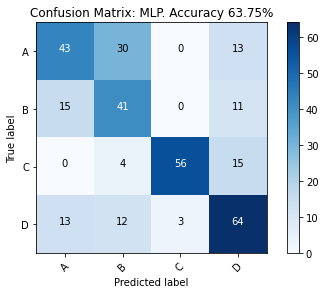

In [ ]:
predictions = MLP_model.predict(
      x=test_data
    , batch_size=1
    , verbose=2
)

# Rounding predictions values to map into confusion matrix
rounded_predictions = np.argmax(predictions, axis=-1)

cm_plot_labels = ['A', 'B', 'C', 'D']
cm = confusion_matrix(y_true=test_label, y_pred=rounded_predictions)
accuracy = accuracy_score(test_label, rounded_predictions) * 100
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f'Confusion Matrix: MLP. Accuracy {accuracy:.02f}%')
print("Per class: ", cm.diagonal()/cm.sum(axis=1))

## LeNet Model

In [ ]:
def get_LeNet_model(input_dim, learning_rate, num_classes):
    InputLayer = tf.keras.layers.InputLayer
    Conv1D = tf.keras.layers.Conv1D
    Dense = tf.keras.layers.Dense
    Flatten = tf.keras.layers.Flatten
    MaxPool2D = tf.keras.layers.MaxPool1D

    model = tf.keras.Sequential(
      [
          InputLayer(input_shape=input_dim),
          Conv1D(32, kernel_size=7, strides=1, activation='relu'),
          MaxPool2D(pool_size=2),
          Conv1D(64, kernel_size=4, strides=1, padding='same', activation='relu'),
          MaxPool2D(pool_size=2),
          Conv1D(96, kernel_size=3, strides=1, activation='relu'),
          MaxPool2D(pool_size=2),
          Flatten(),
          Dense(128, activation=tf.nn.relu),
          Dense(num_classes, activation=tf.nn.softmax)
      ])
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate)

    model.compile(
        loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Expanding dataset dimensions since CNN2D takes in 3 dimensions: HWC
train_data2 = train_data.copy()
train_data2 = np.expand_dims(train_data2, axis=-1)
train_data2.shape

(1264, 26000, 1)

In [ ]:
LeNet_model = get_LeNet_model(train_data2[0].shape, 0.001, len(np.unique(train_label)))
LeNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25994, 32)         256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12997, 32)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12997, 64)         8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6498, 64)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 6496, 96)          18528     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3248, 96)         0

In [ ]:
LeNet_checkpoint_filepath = './LeNet_checkpoint'
LeNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=LeNet_checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
LeNet_model.fit(train_data2, train_label, batch_size=128, epochs=200, validation_split=0.2, shuffle=True, callbacks=[LeNet_checkpoint_callback])

Epoch 1/200
8/8 [==============================] - 22s 1s/step - loss: 2.0533 - accuracy: 0.2591 - val_loss: 1.3952 - val_accuracy: 0.2688
Epoch 2/200
8/8 [==============================] - 4s 565ms/step - loss: 1.3741 - accuracy: 0.3086 - val_loss: 1.3605 - val_accuracy: 0.3360
Epoch 3/200
8/8 [==============================] - 4s 547ms/step - loss: 1.3122 - accuracy: 0.4530 - val_loss: 1.2540 - val_accuracy: 0.3636
Epoch 4/200
8/8 [==============================] - 4s 591ms/step - loss: 1.1560 - accuracy: 0.5470 - val_loss: 1.0390 - val_accuracy: 0.6285
Epoch 5/200
8/8 [==============================] - 4s 553ms/step - loss: 0.8408 - accuracy: 0.7883 - val_loss: 0.6383 - val_accuracy: 0.8735
Epoch 6/200
8/8 [==============================] - 2s 254ms/step - loss: 0.5259 - accuracy: 0.8595 - val_loss: 0.5008 - val_accuracy: 0.8419
Epoch 7/200
8/8 [==============================] - 2s 253ms/step - loss: 0.3582 - accuracy: 0.8853 - val_loss: 0.3953 - val_accuracy: 0.8735
Epoch 8/200
8/8

317/317 - 1s - 846ms/epoch - 3ms/step
Confusion matrix, without normalization
[[75  0  2  1]
 [ 1 80  0  0]
 [ 0  0 68  0]
 [ 2  0  1 87]]
Per class:  [0.96153846 0.98765432 1.         0.96666667]


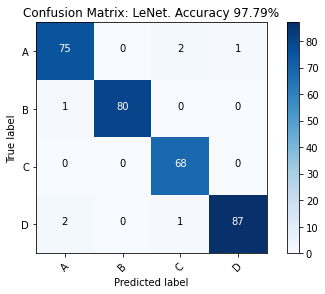

In [ ]:
predictions_2 = LeNet_model.predict(
      x=test_data
    , batch_size=1
    , verbose=2
)

# Rounding predictions values to map into confusion matrix
rounded_predictions_2 = np.argmax(predictions_2, axis=-1)

cm_plot_labels_2 = ['A', 'B', 'C', 'D']
cm2 = confusion_matrix(y_true=test_label, y_pred=rounded_predictions_2)
accuracy_2 = accuracy_score(test_label, rounded_predictions_2) * 100
plot_confusion_matrix(cm=cm2, classes=cm_plot_labels_2, title=f'Confusion Matrix: LeNet. Accuracy {accuracy_2:.02f}%')
print("Per class: ", cm2.diagonal()/cm2.sum(axis=1))

# KNN

In [ ]:
from __future__ import print_function
import numpy as np
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.metrics import accuracy_score

In [ ]:
def myweight(distances):
  sigma2 = .4 # we can change this number
  return np.exp(-distances**2/sigma2)

In [ ]:
#Tham so thu 3 co the la myweigt hoac distance
model = neighbors.KNeighborsClassifier(n_neighbors = 7, p = 2, weights = myweight)

In [ ]:

model.fit(train_data, train_label)
y_pred = model.predict(test_data)
print("Accuracy of 7NN: %.2f %%" %(100*accuracy_score(test_label, y_pred)))


Accuracy of 7NN: 92.50 %


# Naive Bayes

In [ ]:
from __future__ import print_function
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [ ]:
import math
model = GaussianNB()
model.partial_fit(train_data, train_label,np.unique(train_label))
y_pred2 = model.predict(test_data)
print(accuracy_score(test_label, y_pred2)*100)

58.4375


# Decision Tree

In [ ]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(train_data, train_label)
l = clf_tree.predict(test_data)
print(accuracy_score(test_label, l)*100)

79.0625


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier()
model3.fit(train_data, train_label)
print(model3.score(test_data, test_label))
print(model3.score(train_data, train_label))

0.621875
1.0


# SVM

In [ ]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
clf = OneVsRestClassifier(SVC()).fit(train_data, train_label)
y_pred2 = clf.predict(test_data)
print(accuracy_score(test_label, y_pred2)*100)


92.1875


In [ ]:
K-Means